In [95]:
# data munging
import pandas as pd
import numpy as np
import random

# visualization

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import cm
from ipywidgets import interact
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)

In [96]:
all_user_data_df = pd.DataFrame.from_csv('generating_user_behavioral_data.csv')
all_user_data_df[['feature1', 'feature2', 'feature3']] = all_user_data_df[['feature1', 'feature2', 'feature3']].astype(int)
all_user_data_df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country
0,512ff3c3-fa27-442d-a116-126ec5e46d0b,2016-09-01,2,1,1,Android,False,AU
1,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-10-01,3,2,1,Android,False,AU
2,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-11-01,10,8,6,Android,False,AU
3,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2016-12-01,2,1,1,Android,False,AU
4,8a7b8862-4490-4a45-89e4-6f909e09c3f6,2017-01-01,10,8,6,Android,False,AU


In [97]:
len(all_user_data_df['device_uuid'].unique())

9265

## Simulating difference in retention (iOS vs. Android)

In [98]:
# all the data is equally distributed across all features we want to remove a certain values to be able to visualize
# the difference in retention
# we want to simulate a 50% lower retention of iOS users compared to Android users

In [99]:
# extract only iOS users and check whether they have more than a month of usage data
ios_lt_df = pd.DataFrame(all_user_data_df[all_user_data_df['platform'] == 'iOS'].groupby('device_uuid').count()['date'] > 1).reset_index()
len(ios_lt_df)

6480

In [100]:
# extract the device_uuids from users that have more than a month of data
ios_lt_df= ios_lt_df[ios_lt_df['date'] == True]
ios_lt_df.reset_index(drop=True, inplace=True)
len(ios_lt_df)

2975

In [101]:
# assign 0 or 1 to all users that have more than a month of usage data
ios_lt_df['binary_split'] = pd.Series(np.random.randint(2, size=len(ios_lt_df)))

# extract only users that don't have the assigned values of 0 (50/50 split)
ios_lt_df = ios_lt_df[ios_lt_df['binary_split'] == 1.0]

# extract devices uuids into a list
ios_lt_devices = ios_lt_df['device_uuid']

len(ios_lt_devices)

1552

In [102]:
# removing the assigned devices
all_user_data_df_updated = all_user_data_df.query("device_uuid not in @ios_lt_devices")

In [103]:
len(all_user_data_df_updated['device_uuid'].unique())

7713

In [104]:
num_removed_devices = len(all_user_data_df['device_uuid'].unique()) -  len(all_user_data_df_updated['device_uuid'].unique())
len(ios_lt_devices) == num_removed_devices

True

In [105]:
all_user_data_df = all_user_data_df_updated.copy()

## 1. Segmenting users

In [106]:
def segmenting(df, country, platform, user_registered):
    
    df['Date'] = pd.to_datetime(df['date'])

    # for each categorical (segmentation) feature
    if country != 'All countries':
        df = df[df['country'] == country]
        
    if platform != 'All platforms':
        df = df[df['platform'] == platform]
        
    if user_registered != 'True and False':
        df = df[df['user_registered'] == user_registered]
        
    return df

In [107]:
# NL / AU / FR
country_values = ['All countries'] + list(all_user_data_df['country'].unique())

# iOS / Android
platform_values = ['All platforms'] + list(all_user_data_df['platform'].unique())

# True / False
user_registered_values = ['True and False'] + list(all_user_data_df['user_registered'].unique())

In [109]:
country_value = 'NL'
platform_value = 'iOS'
user_registered_value = False

df = segmenting(all_user_data_df.copy(), country=country_value, platform=platform_value, user_registered=user_registered_value)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,Date
30,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-08-01,8,6,4,iOS,False,NL,2016-08-01
31,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-09-01,3,2,1,iOS,False,NL,2016-09-01
32,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-10-01,2,1,1,iOS,False,NL,2016-10-01
33,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-11-01,9,7,5,iOS,False,NL,2016-11-01
34,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-12-01,4,3,2,iOS,False,NL,2016-12-01


## 2. Building cohorts

In [112]:
def preprocess_cohorting(df):
    df['sum'] = df['feature1'] + df['feature2'] + df['feature3']
    df['date'] = pd.to_datetime(df['date'])
    
    to_month = lambda x: x.strftime('%Y-%m')
    df['onboarded_period'] = df['date'].apply(to_month)
    
    df.set_index('device_uuid', inplace=True)
    df['cohort_group'] = df.groupby(level=0)['date'].min().apply(lambda x:  x.strftime('%Y-%m'))
    df.reset_index(inplace=True)
    
    return df

In [113]:
# step 1
df = preprocess_cohorting(df)
df.head()

,device_uuid,date,feature1,feature2,feature3,platform,user_registered,country,Date,sum,onboarded_period,cohort_group
0,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-08-01,8,6,4,iOS,False,NL,2016-08-01,18,2016-08,2016-08
1,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-09-01,3,2,1,iOS,False,NL,2016-09-01,6,2016-09,2016-08
2,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-10-01,2,1,1,iOS,False,NL,2016-10-01,4,2016-10,2016-08
3,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-11-01,9,7,5,iOS,False,NL,2016-11-01,21,2016-11,2016-08
4,cb9e10ff-cbff-46c4-8ac1-69de19e5aeea,2016-12-01,4,3,2,iOS,False,NL,2016-12-01,9,2016-12,2016-08


In [114]:
def build_cohort_data(df):
    grouped = df.groupby(['cohort_group', 'onboarded_period'])

    # count the unique users, orders, and total revenue per Group + Period
    cohorts = grouped.agg({'device_uuid': pd.Series.nunique,
                      'sum': np.sum})

    # make the column names more meaningful
    cohorts.rename(columns={'device_uuid': 'all_users',
                       'sum': 'all_num_events'}, inplace=True)
    return cohorts

In [115]:
# step 2
cohorts = build_cohort_data(df)
cohorts.head()

all_num_events  all_users
cohort_group onboarded_period                           
2016-02      2016-02                     3914        237
             2016-03                     1035         63
             2016-04                     1033         60
             2016-05                      844         55
             2016-06                      867         51

In [116]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    
    df['cohort_period'] = np.arange(len(df)) + 0
    return df

In [117]:
# step 3
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

all_num_events  all_users  cohort_period
cohort_group onboarded_period                                          
2016-02      2016-02                     3914        237              0
             2016-03                     1035         63              1
             2016-04                     1033         60              2
             2016-05                      844         55              3
             2016-06                      867         51              4

In [118]:
def cohort_reindex_and_group_size(df):
    # reindex the dataframe
    df.reset_index(inplace=True)
    df.set_index(['cohort_group', 'cohort_period'], inplace=True)
    cohort_group_size = df['all_users'].groupby(level=0).first()
    return df, cohort_group_size

In [119]:
# step 4
cohorts, cohort_group_size = cohort_reindex_and_group_size(cohorts)
cohort_group_size

cohort_group
2016-02    237
2016-03    232
2016-04    220
2016-05    240
2016-06    205
2016-07    250
2016-08    225
2016-09    226
2016-10    218
Name: all_users, dtype: int64

In [120]:
def calculate_user_retention(df, cohort_group_size):
    df = df['all_users'].unstack(0).divide(cohort_group_size, axis=1)
    return df

In [121]:
# step 5
user_retention = calculate_user_retention(cohorts, cohort_group_size)
user_retention.head()

cohort_group,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10
cohort_period,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000
1,0.265823,0.306034,0.309091,0.250000,0.263415,0.304,0.333333,0.296460,0.252294
2,0.253165,0.280172,0.268182,0.233333,0.234146,0.288,0.302222,0.283186,0.220183
3,0.232068,0.262931,0.259091,0.208333,0.209756,0.268,0.288889,0.269912,0.197248
4,0.215190,0.237069,0.227273,0.195833,0.185366,0.252,0.271111,0.247788,0.188073


In [126]:
# combining all cohort functions into one
# used for interactive visualization

def build_cohorts(df):
    
    # step 1
    df = preprocess_cohorting(df)
    
    # step 2
    cohorts = build_cohort_data(df)
    
    # step 3
    cohorts_s1 = cohorts.groupby(level=0).apply(cohort_period)
    
    # step 4
    cohorts_s2, cohort_group_size = cohort_reindex_and_group_size(cohorts_s1)
    
    # step 5
    user_retention = calculate_user_retention(cohorts_s2, cohort_group_size)
    
    return user_retention

## 3. Visualization

### 3.1. Retention curves

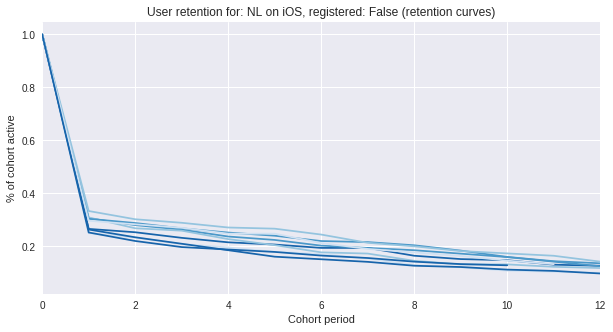

In [127]:
title = 'User retention for: ' + country_value + ' on ' + platform_value +', registered: ' + str(user_registered_value) 

fig, ax = plt.subplots(figsize=(10,5))
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)


for i in range(0, len(user_retention.columns)):
    plt.plot(user_retention[user_retention.columns[i]])

plt.title(title + ' (retention curves)')
# plt.imshow(g, cmap='Blues',  interpolation='nearest')
plt.xlabel("Cohort period")
plt.ylabel("% of cohort active")
plt.xlim(0, 12)
plt.show()

### 3.2. Heatmap

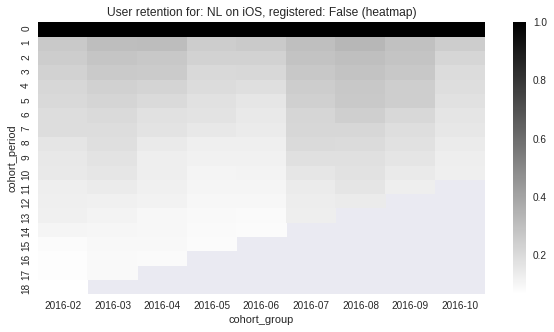

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(user_retention, cmap="binary", ax=ax)
ax.set_title(title + ' (heatmap)')
plt.show()

## Interactive visualization

In [125]:
def func_cohort_analysis(country, platform, user_registered):
    
    # segmenting users
    segmented_user_events_df = segmenting(all_user_data_df.copy(), country=country, platform=platform, user_registered=user_registered)
    
    # building cohorts
    user_retention = build_cohorts(segmented_user_events_df)
    
    

    # visualization 1 - retention curve
    
    title = 'User retention for: ' + country + ' on ' + platform +', registered: ' + str(user_registered) 
    fig, ax = plt.subplots(figsize=(10,5))
    
    for i in range(0, len(user_retention.columns)):
        plt.plot(user_retention[user_retention.columns[i]])
        
    plt.title(title + ' (retention curves)')
    plt.xlabel("Cohort period")
    plt.ylabel("% of cohort active")
    plt.xlim(0, 12)
    plt.show()
    
    
    
    # visualization 2 - heatmap
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(user_retention, cmap="binary", ax=ax)
    ax.set_title(title + ' (heatmap)')
    plt.show()
    

    
    
interact(func_cohort_analysis, country=country_values , platform=platform_values, user_registered=user_registered_values);